<a href="https://colab.research.google.com/github/KadenC2026/2024-2025-Summer-Research/blob/main/Sp500analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Risk Management: Copula Estimation with S&P 500 and Bond ETF

This notebook demonstrates advanced techniques for modeling and analyzing the dependence structure between the S&P 500 (SPY) and a bond ETF (TLT) using parametric copula methods. The workflow includes data acquisition, marginal fitting, copula estimation, simulation, and risk measure calculation (VaR, ES).


## Project Overview

In this project, we:

- Download daily returns for SPY (S&P 500 ETF) and TLT (Bond ETF)
- Fit and compare marginal distributions for each asset
- Estimate and compare dependence structures using copula models (Gaussian, vine)
- Simulate joint returns and compute portfolio risk measures (VaR, ES)
- Visualize and interpret the results <br>

This approach is widely used in quantitative risk management for portfolio modeling, risk aggregation, and stress testing.

In [16]:
# 1. Import Required Libraries
!pip install yfinance copulas statsmodels seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from copulas.multivariate import GaussianMultivariate, VineCopula
from copulas.univariate import GaussianKDE, StudentTUnivariate
from statsmodels.distributions.empirical_distribution import ECDF

# Set plotting style for consistency
sns.set(style='whitegrid')

In [17]:
# 2. Download and Prepare Data
# Download S&P 500 (SPY) and Bond ETF (TLT) data
symbols = ['SPY', 'TLT']
raw_data = yf.download(symbols, start='2015-01-01', end='2025-01-01')

# Handle both single and multi-index columns for robustness
if isinstance(raw_data.columns, pd.MultiIndex):
    # Use 'Close' prices for both SPY and TLT
    data = raw_data['Close'][symbols]
else:
    data = raw_data[['Close']]

data = data.dropna()
print('First 5 rows of price data:')
print(data.head())

/tmp/ipython-input-17-2253296101.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(symbols, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


First 5 rows of price data:
Ticker             SPY         TLT
Date                              
2015-01-02  171.568039   96.881798
2015-01-05  168.469589   98.403717
2015-01-06  166.882812  100.176659
2015-01-07  168.962372   99.978798
2015-01-08  171.960541   98.654800


In [18]:
# 3. Calculate Daily Log Returns

# Calculate daily log returns using the formula: log(current_price / previous_price)
# Drop the first row as it will be NaN due to the lack of a previous price
returns = np.log(data / data.shift(1)).dropna()

# Display the first 5 rows of the calculated log returns
print('First 5 rows of log returns:')
returns.head()

First 5 rows of log returns:


Ticker,SPY,TLT
Date,,
2015-01-05,-0.018225,0.015587
2015-01-06,-0.009463,0.017857
2015-01-07,0.012384,-0.001977
2015-01-08,0.017589,-0.013331
2015-01-09,-0.008046,0.010893


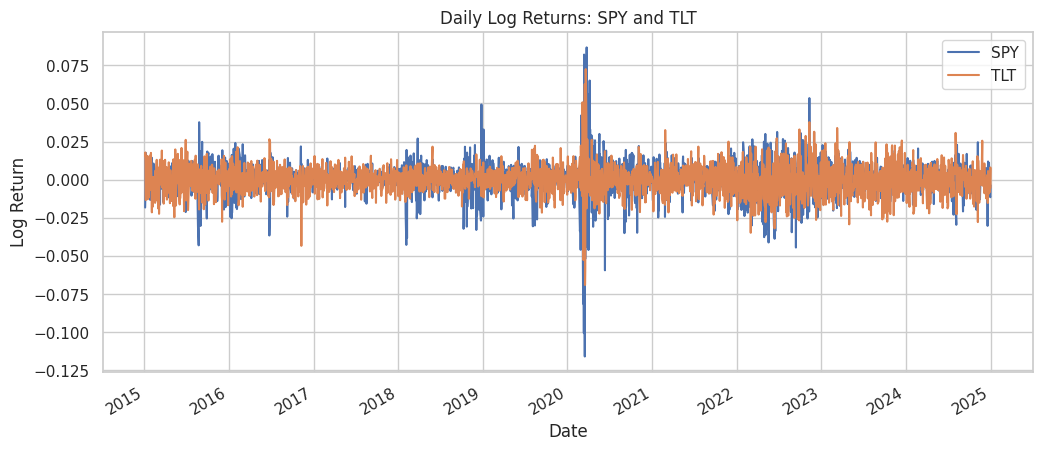

In [19]:
# 4. Visualize Daily Log Returns
plt.figure(figsize=(12, 5))
returns.plot(ax=plt.gca())
plt.title('Daily Log Returns: SPY and TLT')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.legend(['SPY', 'TLT'])
plt.show()

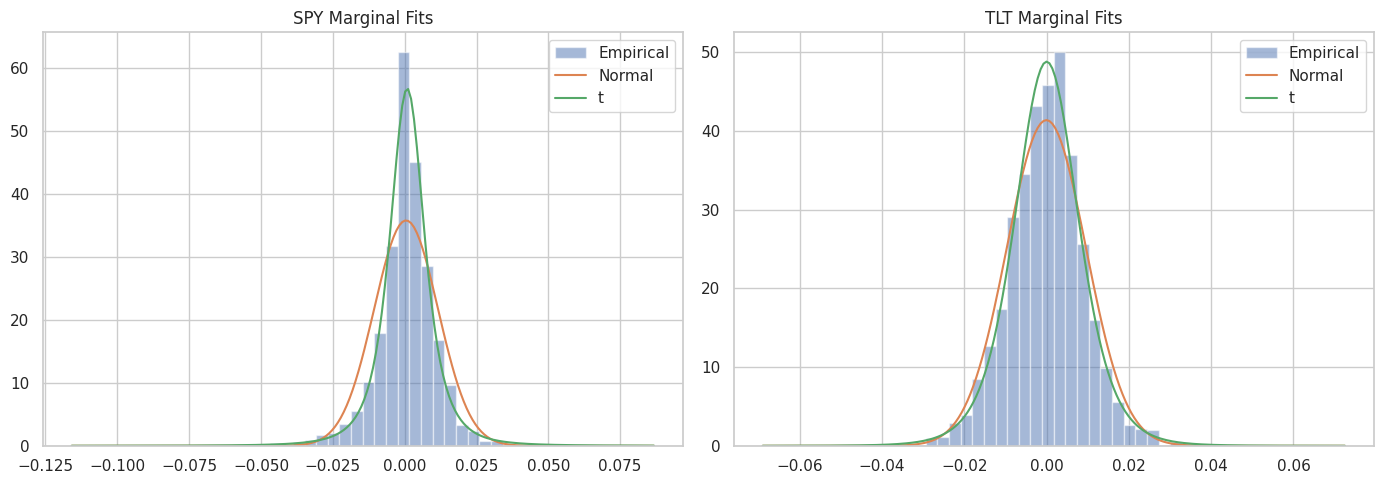

In [20]:
# 5. Fit Marginal Distributions (Normal, t, Empirical CDF)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, asset in enumerate(['SPY', 'TLT']):
    x = returns[asset]
    # Plot histogram
    axes[i].hist(x, bins=50, density=True, alpha=0.5, label='Empirical')
    # Fit normal distribution
    mu, sigma = stats.norm.fit(x)
    xx = np.linspace(x.min(), x.max(), 200)
    axes[i].plot(xx, stats.norm.pdf(xx, mu, sigma), label='Normal')
    # Fit t distribution
    t_params = stats.t.fit(x)
    axes[i].plot(xx, stats.t.pdf(xx, *t_params), label='t')
    axes[i].set_title(f'{asset} Marginal Fits')
    axes[i].legend()
plt.tight_layout()
plt.show()

In [21]:
# 6. Transform Returns to Uniform Scale (Pseudo-Observations)

# Transform returns to uniform scale (pseudo-observations) using empirical CDFs
u = pd.DataFrame(index=returns.index)
for asset in ['SPY', 'TLT']:
    ecdf = ECDF(returns[asset])
    u[asset] = ecdf(returns[asset])
print('First 5 rows of pseudo-observations:')
u.head()

First 5 rows of pseudo-observations:


,SPY,TLT
Date,,
2015-01-05,0.042147,0.957058
2015-01-06,0.115706,0.972962
2015-01-07,0.909742,0.405567
2015-01-08,0.964612,0.076740
2015-01-09,0.139960,0.901789


In [22]:
# 7. Fit Gaussian Copula

# Fit Gaussian copula using copulas library
from copulas.multivariate import GaussianMultivariate

# Gaussian copula
gauss_cop = GaussianMultivariate()
gauss_cop.fit(u)

print('Gaussian copula correlation matrix:')
print(gauss_cop.correlation)

Gaussian copula correlation matrix:
          SPY       TLT
SPY  1.000000 -0.184049
TLT -0.184049  1.000000


In [23]:
# 8. Fit a Vine Copula (Flexible Dependence Modeling)
vine = VineCopula('center')
vine.fit(u)

# Note: log_likelihood is not available in this version of copulas
print("Vine copula fitted. (Log-likelihood comparison not available in this version.)")

/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(


Vine copula fitted. (Log-likelihood comparison not available in this version.)


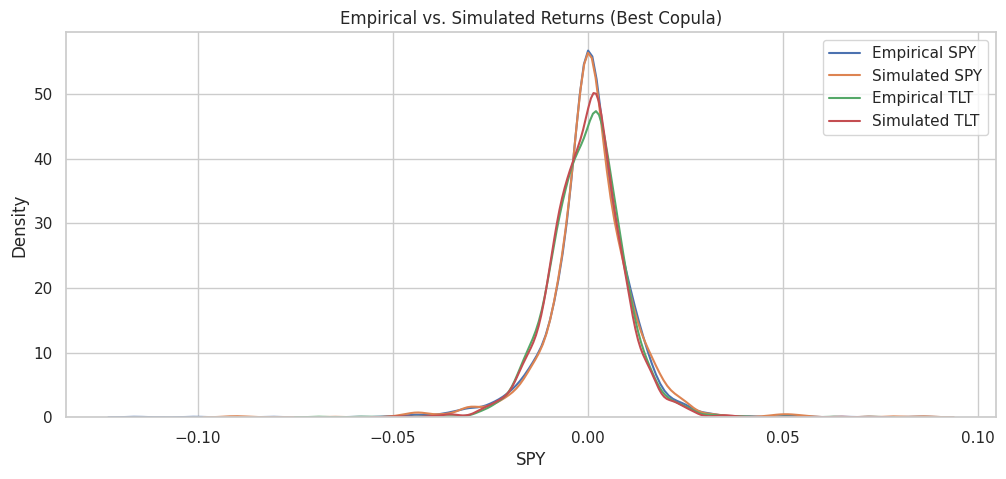

In [24]:
# 9. Simulate Joint Returns from the Copula Model
# Here, we use the Gaussian copula for demonstration
best_copula = gauss_cop
sim_u = best_copula.sample(len(u))

# Inverse transform to returns using empirical quantiles
def inv_transform(u_col, orig):
    quantiles = np.quantile(orig, u_col)
    return quantiles
sim_returns = pd.DataFrame(index=returns.index)
for i, asset in enumerate(['SPY', 'TLT']):
    sim_returns[asset] = np.quantile(returns[asset], sim_u.iloc[:, i])

# Compare simulated and empirical returns visually
plt.figure(figsize=(12, 5))
sns.kdeplot(returns['SPY'], label='Empirical SPY')
sns.kdeplot(sim_returns['SPY'], label='Simulated SPY')
sns.kdeplot(returns['TLT'], label='Empirical TLT')
sns.kdeplot(sim_returns['TLT'], label='Simulated TLT')
plt.title('Empirical vs. Simulated Returns (Best Copula)')
plt.legend()
plt.show()

In [25]:
# 10. Compute Portfolio VaR and ES (Empirical vs. Simulated)
# Set the confidence level and portfolio weights
alpha = 0.05  # 95% confidence level
weights = np.array([0.5, 0.5])  # Equal-weighted portfolio

# Compute portfolio returns for empirical and simulated data
emp_portfolio = returns @ weights
sim_portfolio = sim_returns @ weights

# Calculate VaR and ES for empirical returns
VaR_emp = np.quantile(emp_portfolio, alpha) * -1
ES_emp = emp_portfolio[emp_portfolio <= VaR_emp].mean() * -1

# Calculate VaR and ES for simulated returns
VaR_sim = np.quantile(sim_portfolio, alpha) * -1
ES_sim = sim_portfolio[sim_portfolio <= VaR_sim].mean() * -1

# Display the results
print(f'Empirical Portfolio VaR (5%): {VaR_emp:.4f}')
print(f'Empirical Portfolio ES (5%): {ES_emp:.4f}')
print(f'Simulated Portfolio VaR (5%): {VaR_sim:.4f}')
print(f'Simulated Portfolio ES (5%): {ES_sim:.4f}')

Empirical Portfolio VaR (5%): 0.0103
Empirical Portfolio ES (5%): 0.0004
Simulated Portfolio VaR (5%): 0.0105
Simulated Portfolio ES (5%): 0.0006
